In [52]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
def load_features(folder, label):
    features = []
    labels = []

    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])

    for filename in os.listdir(folder):
        if filename.endswith('.npy'):
            path = os.path.join(folder, filename)
            data = np.load(path)


            features.append(data.flatten())
            labels.append(label)

    return np.array(features), np.array(labels)


real_dir = '../images/CovarianceMatrices/Real/'
genai_dir = '../images/CovarianceMatrices/GenAI/'


real_features, real_labels = load_features(real_dir, 0)
genai_features, genai_labels = load_features(genai_dir, 1)


X = np.concatenate((real_features, genai_features), axis=0)
y = np.concatenate((real_labels, genai_labels), axis=0)

print(f'Total samples loaded: {X.shape[0]}')
print(f'Features per sample: {X.shape[1]} (Should be 50)')

Total samples loaded: 720
Features per sample: 100 (Should be 50)


In [54]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training shape: {X_train_scaled.shape}')
print(f'Testing shape: {X_test_scaled.shape}')

Training shape: (540, 100)
Testing shape: (180, 100)


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC(random_state=42)


param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto'],
    'kernel': ['rbf']
}

print("Running Grid Search to find best SVM settings...")
grid = GridSearchCV(svm, param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train_scaled, y_train)

print(f"\n✅ Best Parameters found: {grid.best_params_}")
print(f"Best Estimator Accuracy: {grid.best_score_:.4f}")


best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)


print("\nFinal Test Set Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'GenAI']))

Running Grid Search to find best SVM settings...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0

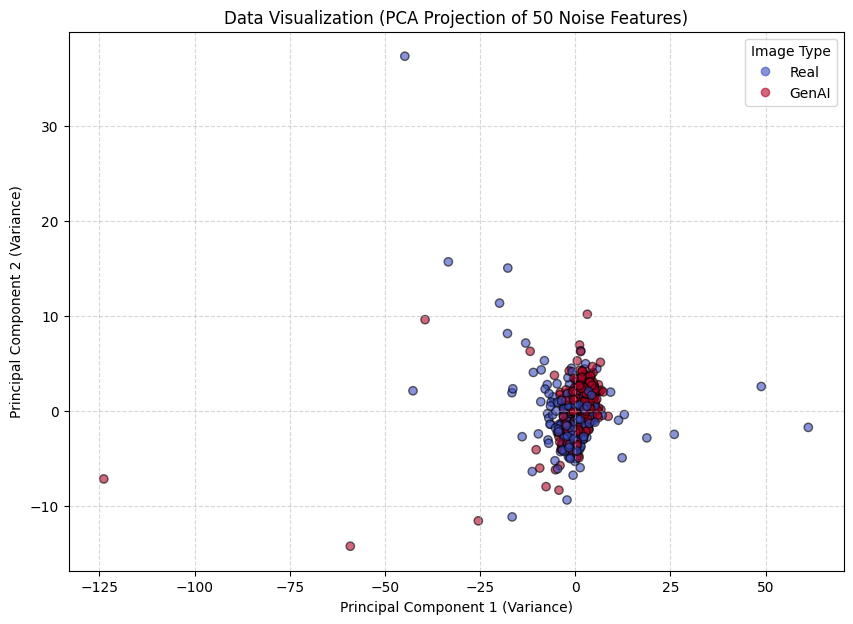

In [56]:
from sklearn.decomposition import PCA

pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, cmap='coolwarm', alpha=0.6, edgecolors='k')

plt.title('Data Visualization (PCA Projection of 50 Noise Features)')
plt.xlabel('Principal Component 1 (Variance)')
plt.ylabel('Principal Component 2 (Variance)')

handles, _ = scatter.legend_elements()
plt.legend(handles, ['Real', 'GenAI'], title="Image Type")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()